<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter4/4_3_%E7%8A%B6%E6%85%8B%E7%A9%BA%E9%96%93%E3%83%A2%E3%83%86%E3%82%99%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title install package
# !pip install arviz
!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [2]:
#@title import packages
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import collections
import numpy as np
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import sts

tfd = tfp.distributions
tf.random.set_seed(42)

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
colors = sns.color_palette('tab10')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
#@title Plotting functions
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast

  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_xlabel('Year')
  ax.set_ylabel('y')
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(10, 3 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  ax.set_xlabel('Year')
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

## ローカルレベルモデル

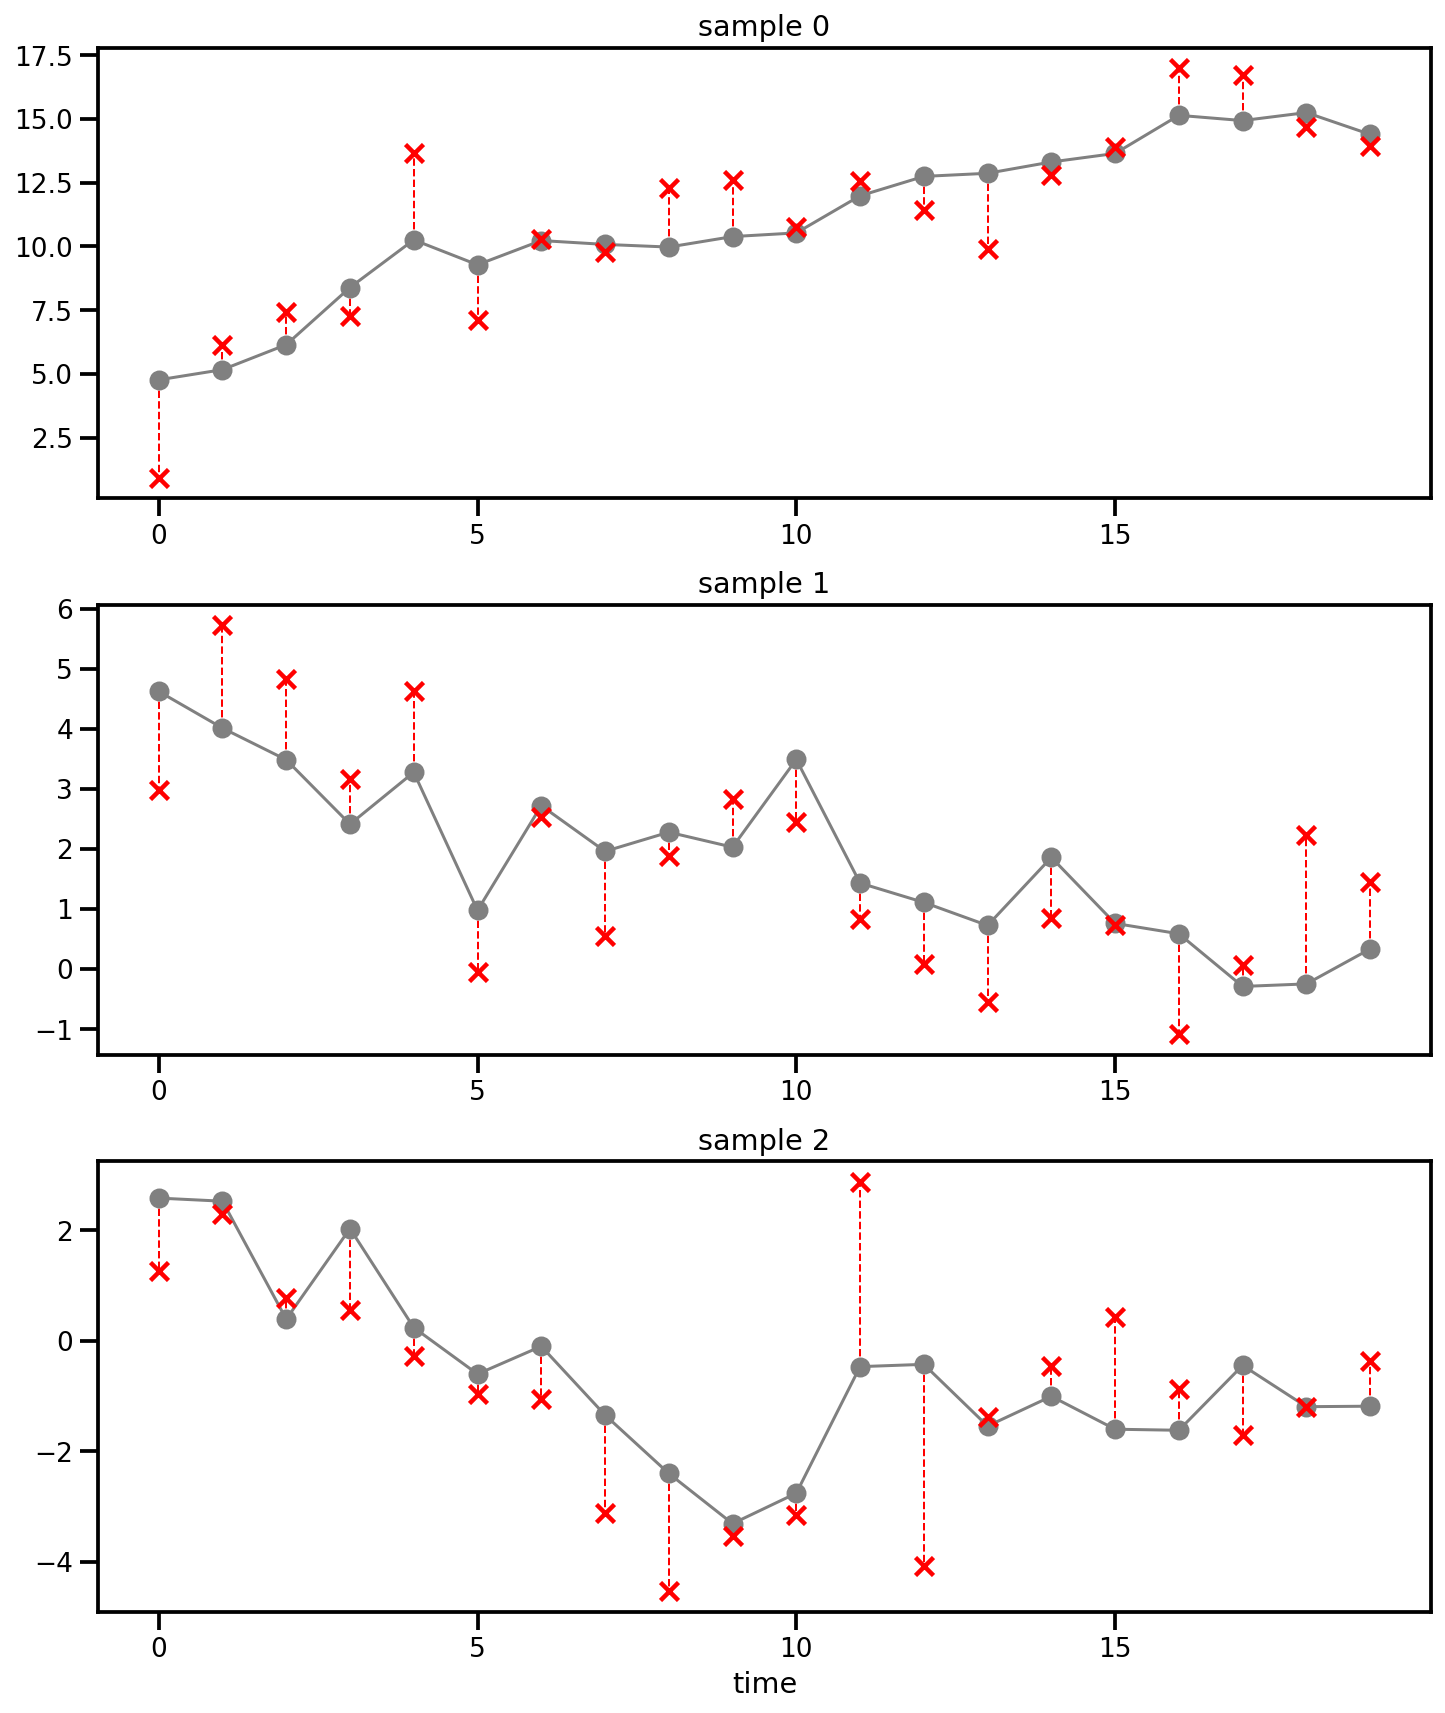

In [4]:
#@title local level model
t = 20
eta_sd = 1.0
eps_sd = 1.5
mu_init = 3.0

n_trial = 3

fig, axes = plt.subplots(n_trial, 1, figsize=(10, 4*n_trial))
x = np.arange(t)

for i in range(n_trial):
    np.random.seed(i)    
    eta = np.random.normal(0, eta_sd, t)
    eps = np.random.normal(0, eps_sd, t)

    mu = mu_init + eta.cumsum()
    y = mu + eps

    ax = axes[i]
    ax.plot(x, mu, color='gray', lw=1.5, marker='o')
    ax.scatter(x, y, color='r', marker='x', zorder=3)
    ax.vlines(x, mu, y, color='r', lw=1, ls='--')
    # ax.set_ylabel('y')
    ax.set_xticks(range(0, 20, 5))
    ax.set_title(f'sample {i}')

ax.set_xlabel('time')
plt.tight_layout()

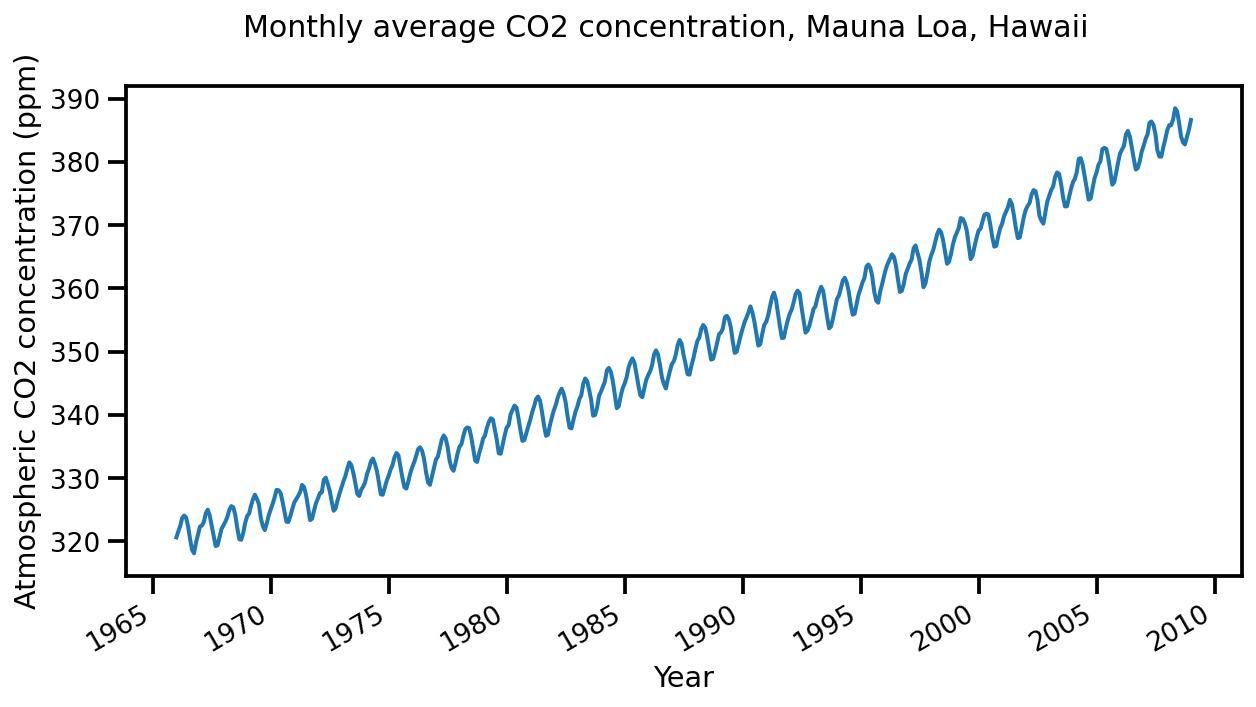

In [5]:
#@title load and plot data
y = np.array('320.62,321.60,322.39,323.70,324.08,323.75,322.38,320.36,318.64,318.10,319.78,321.03,322.33,322.50,323.04,324.42,325.00,324.09,322.54,320.92,319.25,319.39,320.73,321.96,322.57,323.15,323.89,325.02,325.57,325.36,324.14,322.11,320.33,320.25,321.32,322.89,324.00,324.42,325.63,326.66,327.38,326.71,325.88,323.66,322.38,321.78,322.85,324.12,325.06,325.98,326.93,328.14,328.08,327.67,326.34,324.69,323.10,323.06,324.01,325.13,326.17,326.68,327.17,327.79,328.92,328.57,327.36,325.43,323.36,323.56,324.80,326.01,326.77,327.63,327.75,329.73,330.07,329.09,328.04,326.32,324.84,325.20,326.50,327.55,328.55,329.56,330.30,331.50,332.48,332.07,330.87,329.31,327.51,327.18,328.16,328.64,329.35,330.71,331.48,332.65,333.09,332.25,331.18,329.39,327.43,327.37,328.46,329.57,330.40,331.40,332.04,333.31,333.97,333.60,331.90,330.06,328.56,328.34,329.49,330.76,331.75,332.56,333.50,334.58,334.88,334.33,333.05,330.94,329.30,328.94,330.31,331.68,332.93,333.42,334.70,336.07,336.75,336.27,334.92,332.75,331.59,331.16,332.40,333.85,334.97,335.38,336.64,337.76,338.01,337.89,336.54,334.68,332.76,332.55,333.92,334.95,336.23,336.76,337.96,338.88,339.47,339.29,337.73,336.09,333.92,333.86,335.29,336.73,338.01,338.36,340.07,340.77,341.47,341.17,339.56,337.60,335.88,336.02,337.10,338.21,339.24,340.48,341.38,342.51,342.91,342.25,340.49,338.43,336.69,336.86,338.36,339.61,340.75,341.61,342.70,343.57,344.14,343.35,342.06,339.81,337.98,337.86,339.26,340.49,341.38,342.52,343.10,344.94,345.76,345.32,343.98,342.38,339.87,339.99,341.15,342.99,343.70,344.50,345.28,347.06,347.43,346.80,345.39,343.28,341.07,341.35,342.98,344.22,344.97,345.99,347.42,348.35,348.93,348.25,346.56,344.67,343.09,342.80,344.24,345.56,346.30,346.95,347.85,349.55,350.21,349.55,347.94,345.90,344.85,344.17,345.66,346.90,348.02,348.48,349.42,350.99,351.85,351.26,349.51,348.10,346.45,346.36,347.81,348.96,350.43,351.73,352.22,353.59,354.22,353.79,352.38,350.43,348.73,348.88,350.07,351.34,352.76,353.07,353.68,355.42,355.67,355.12,353.90,351.67,349.80,349.99,351.30,352.52,353.66,354.70,355.38,356.20,357.16,356.23,354.81,352.91,350.96,351.18,352.83,354.21,354.72,355.75,357.16,358.60,359.34,358.24,356.17,354.02,352.15,352.21,353.75,354.99,355.99,356.72,357.81,359.15,359.66,359.25,357.02,355.00,353.01,353.31,354.16,355.40,356.70,357.17,358.38,359.46,360.28,359.60,357.57,355.52,353.69,353.99,355.34,356.80,358.37,358.91,359.97,361.26,361.69,360.94,359.55,357.48,355.84,356.00,357.58,359.04,359.97,361.00,361.64,363.45,363.80,363.26,361.89,359.45,358.05,357.75,359.56,360.70,362.05,363.24,364.02,364.71,365.41,364.97,363.65,361.48,359.45,359.61,360.76,362.33,363.18,363.99,364.56,366.36,366.80,365.63,364.47,362.50,360.19,360.78,362.43,364.28,365.33,366.15,367.31,368.61,369.30,368.88,367.64,365.78,363.90,364.23,365.46,366.97,368.15,368.87,369.59,371.14,371.00,370.35,369.27,366.93,364.64,365.13,366.68,368.00,369.14,369.46,370.51,371.66,371.83,371.69,370.12,368.12,366.62,366.73,368.29,369.53,370.28,371.50,372.12,372.86,374.02,373.31,371.62,369.55,367.96,368.09,369.68,371.24,372.44,373.08,373.52,374.85,375.55,375.40,374.02,371.48,370.70,370.25,372.08,373.78,374.68,375.62,376.11,377.65,378.35,378.13,376.61,374.48,372.98,373.00,374.35,375.69,376.79,377.36,378.39,380.50,380.62,379.55,377.76,375.83,374.05,374.22,375.84,377.44,378.34,379.61,380.08,382.05,382.24,382.08,380.67,378.67,376.42,376.80,378.31,379.96,381.37,382.02,382.56,384.37,384.92,384.03,382.28,380.48,378.81,379.06,380.14,381.66,382.58,383.71,384.34,386.23,386.41,385.87,384.45,381.84,380.86,380.86,382.36,383.61,385.07,385.84,385.83,386.77,388.51,388.05,386.25,384.08,383.09,382.78,384.01,385.11,386.65,387.12,388.52,389.57,390.16,389.62,388.07,386.08,384.65,384.33,386.05,387.49,388.55,390.07,391.01,392.38,393.22,392.24,390.33,388.52,386.84,387.16,388.67,389.81,391.30,391.92,392.45,393.37,394.28,393.69,392.59,390.21,389.00,388.93,390.24,391.80,393.07,393.35,394.36,396.43,396.87,395.88,394.52,392.54,391.13,391.01,392.95,394.34,395.61,396.85,397.26,398.35,399.98,398.87,397.37,395.41,393.39,393.70,395.19,396.82,397.92,398.10,399.47,401.33,401.88,401.31,399.07,397.21,395.40,395.65,397.23,398.79,399.85,400.31,401.51,403.45,404.10,402.88,401.61,399.00,397.50,398.28,400.24,401.89,402.65,404.16,404.85,407.57,407.66,407.00,404.50,402.24,401.01,401.50,403.64,404.55,406.07,406.64,407.06,408.95,409.91,409.12,407.20,405.24,403.27,403.64,405.17,406.75,408.05,408.34,409.25,410.30,411.30,410.88,408.90,407.10,405.59,405.99,408.12,409.23,410.92'.split(',')).astype(np.float32)

num_forecast_steps = 12 * 10 # Forecast the final ten years, given previous data
y_train = y[:-num_forecast_steps]
y_test = y[-num_forecast_steps:]

dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")
x_loc = mdates.YearLocator(5)
x_fmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(dates[:-num_forecast_steps], y_train, lw=2, label="training data")
ax.xaxis.set_major_locator(x_loc)
ax.xaxis.set_major_formatter(x_fmt)
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.suptitle("Monthly average CO2 concentration, Mauna Loa, Hawaii",
             fontsize=15)
fig.autofmt_xdate()

In [6]:
def build_llevel_model(observed_time_series):
    """モデルの定義
    """
    # 状態成分
    level = sts.LocalLevel(observed_time_series=observed_time_series)
    # 各状態成分（今回は1つのみ）と観測誤差を加算
    model = sts.Sum([level], observed_time_series=observed_time_series)
    return model


def variational_inference(model, observed_time_series, num_variational_steps):
    """変分推論
    """
    variational_posteriors = sts.build_factored_surrogate_posterior(model)
    optimizer = tf.optimizers.Adam(learning_rate=.1)
    
    # ELBO loss (負のELBO)の最小化
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model.joint_log_prob(
                observed_time_series=observed_time_series),
            surrogate_posterior=variational_posteriors,
            optimizer=optimizer,
            num_steps=num_variational_steps)
        return elbo_loss_curve

    elbo_loss_curve = train()

    # ELBOの推移をプロット
    plt.plot(elbo_loss_curve)
    plt.xlabel('step')
    plt.ylabel('-ELBO')
    
    return variational_posteriors


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
Do not call `graph_parents`.
CPU times: user 51.1 s, sys: 4.25 s, total: 55.4 s
Wall time: 1min 4s


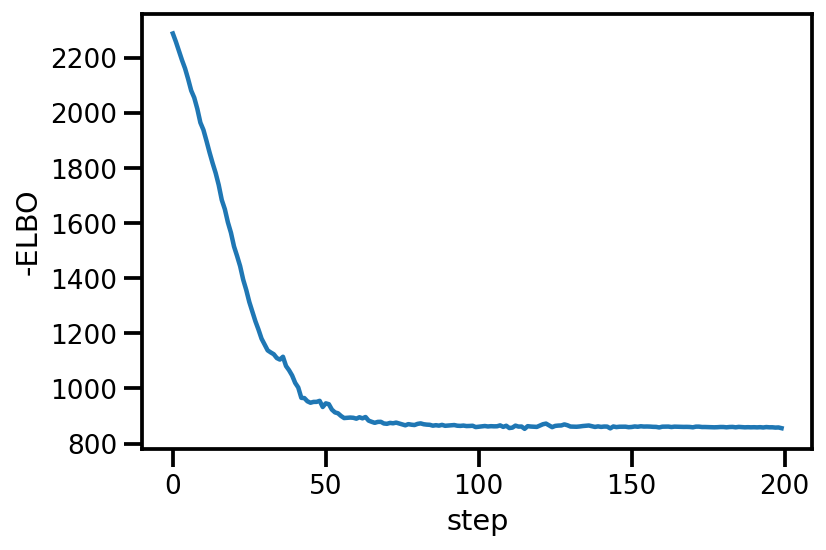

In [7]:
%%time
llevel_model = build_llevel_model(y_train)

num_variational_steps = 200
variational_posteriors = variational_inference(llevel_model, y_train, num_variational_steps)

In [8]:
# 近似事後分布からのサンプルを取得
q_samples = variational_posteriors.sample(50)

print("Inferred parameters:")
for param in llevel_model.parameters:
    print("{0}: {1:.3g} +- {2:.3g}".format(param.name,
                                           np.mean(q_samples[param.name], axis=0),
                                           np.std(q_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.0914 +- 0.0241
LocalLevel/_level_scale: 1.26 +- 0.0388


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7707c1ea10>)

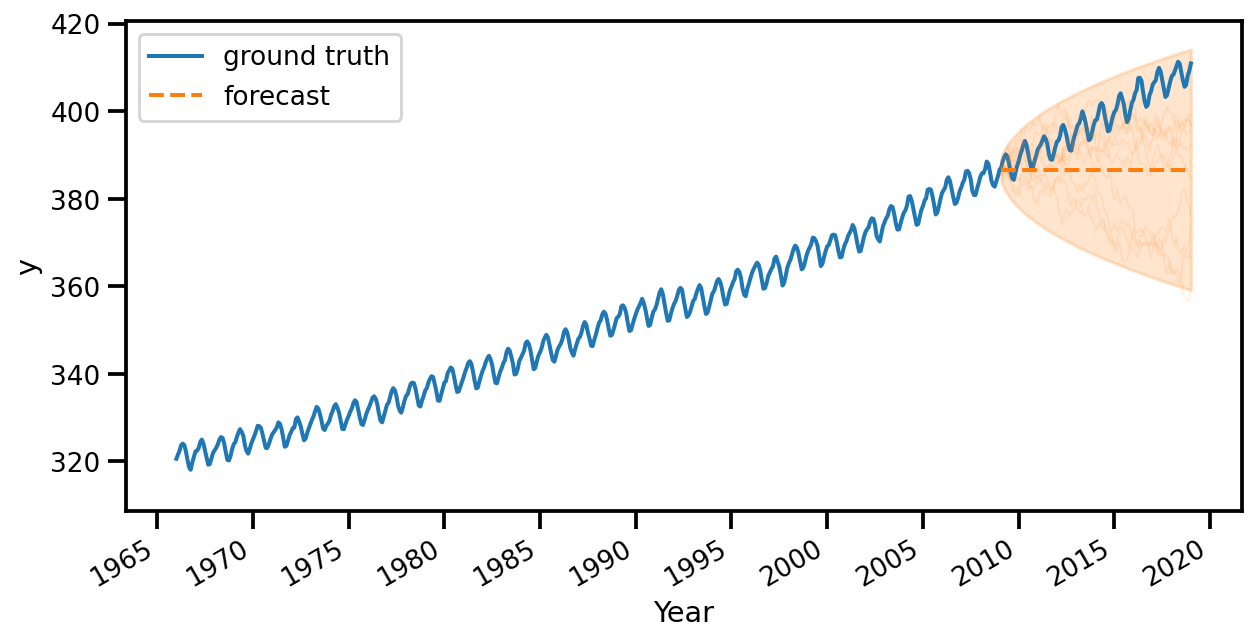

In [9]:
#@title Plot forecast
# パラメータの事後分布からのサンプルを用いて、未来の観測値の予測分布を算出する。
# tfd.MixtureSameFamilyが返される。混合要素数は事後分布からのサンプル数となる。
pred_dist = tfp.sts.forecast(
    model=llevel_model,
    observed_time_series=y_train,
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast_steps)


# 予測分布の平均、標準偏差を算出、予測分布からのサンプルも取得
num_samples=10
(
    pred_mean,
    pred_scale,
    pred_samples
) = (
    pred_dist.mean().numpy()[..., 0],
    pred_dist.stddev().numpy()[..., 0],
    pred_dist.sample(num_samples).numpy()[..., 0]
    )

plot_forecast(dates, y, pred_mean, pred_scale, pred_samples, x_loc, x_fmt)

In [10]:
print('MAE (local level model): {:.1f}'.format(
    mean_absolute_error(pred_mean, y_test)))

MAE (local level model): 11.5


## 構造時系列モデル



### トレンド成分

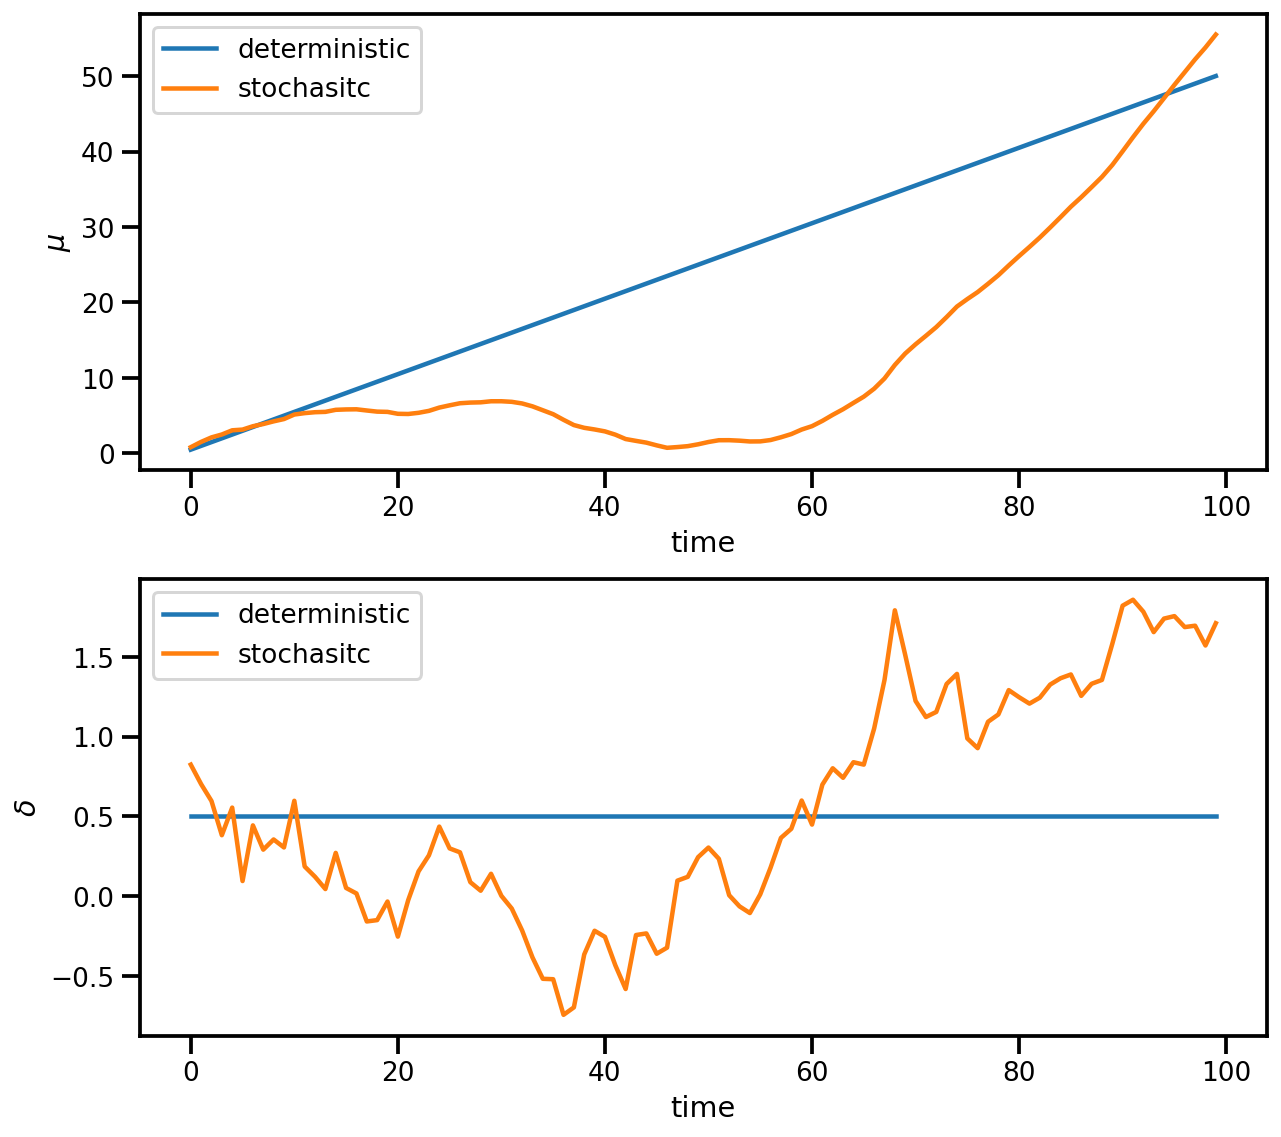

In [11]:
#@title トレンドモデルのイメージ
t = 100
mu_zero = 0
delta_zero = 0.5
sigma_delta = 0.2

np.random.seed(1)
delta_s = delta_zero + np.random.normal(0, sigma_delta, t).cumsum()
delta_d = np.repeat(delta_zero, t)

mu_s = mu_zero + delta_s.cumsum()
mu_d = mu_zero + delta_d.cumsum()

fig, axes = plt.subplots(2, 1, figsize=(9, 8))
ax = axes[0]
ax.plot(mu_d, label='deterministic')
ax.plot(mu_s, label='stochasitc')
ax.set_xlabel('time')
ax.set_ylabel('$\mu$')
ax.legend()

ax = axes[1]
ax.plot(delta_d, label='deterministic')
ax.plot(delta_s, label='stochasitc')
ax.set_xlabel('time')
ax.set_ylabel('$\delta$')
ax.legend()
plt.tight_layout()

### 季節成分

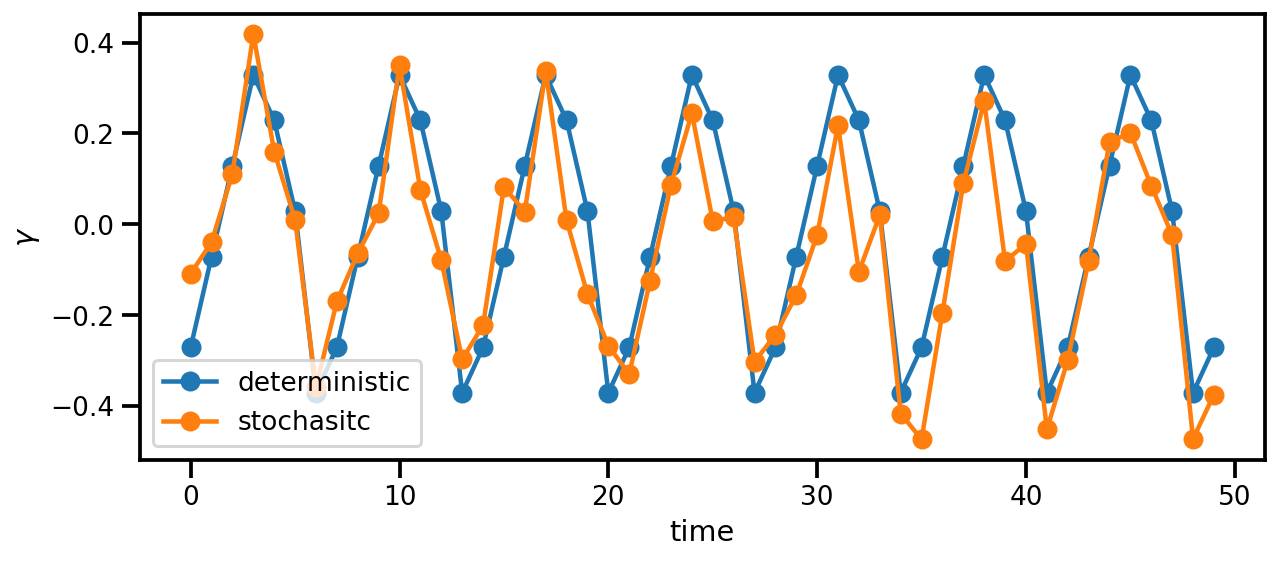

In [12]:
#@title 季節成分のイメージ
t = 50
s = 7
gamma_init = np.array([0.2, 0.4, 0.6, 0.8, 0.7, 0.5, 0.1])
gamma_init -= gamma_init.mean()
sigma_gamma = 0.1

# deterministic
gamma_d = np.tile(gamma_init, t //s + 1)[:t]

np.random.seed(1)
# s(=7) x 8 (各成分が最大８回出現)
# 出現するたびにノイズが加算されるため、ノイズの累積和を算出しておく
noise_cum = np.random.normal(0, sigma_gamma, [s, t // s + 1]).cumsum(axis=1)

# stochasitc
gamma_s = np.tile(gamma_init, t //s + 1)
for i in range(s):
    gamma_s[i::7] += noise_cum[i,:]
gamma_s = gamma_s[:t]

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(gamma_d, marker='o', label='deterministic')
ax.plot(gamma_s, marker='o', label='stochasitc')
ax.set_xlabel('time')
ax.set_ylabel('$\gamma$')
ax.legend()
plt.tight_layout()

In [13]:
def build_trend_seasonal_model(observed_time_series):
    # トレンド成分
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    # 季節成分（12時点周期）
    seasonal = tfp.sts.Seasonal(
        num_seasons=12, observed_time_series=observed_time_series)
    # 各成分を足し合わせる
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

Inferred parameters:
observation_noise_scale: 0.167 +- 0.00983
LocalLinearTrend/_level_scale: 0.183 +- 0.0104
LocalLinearTrend/_slope_scale: 0.00473 +- 0.00192
Seasonal/_drift_scale: 0.0417 +- 0.00935
CPU times: user 1min 54s, sys: 9.69 s, total: 2min 3s
Wall time: 2min 3s


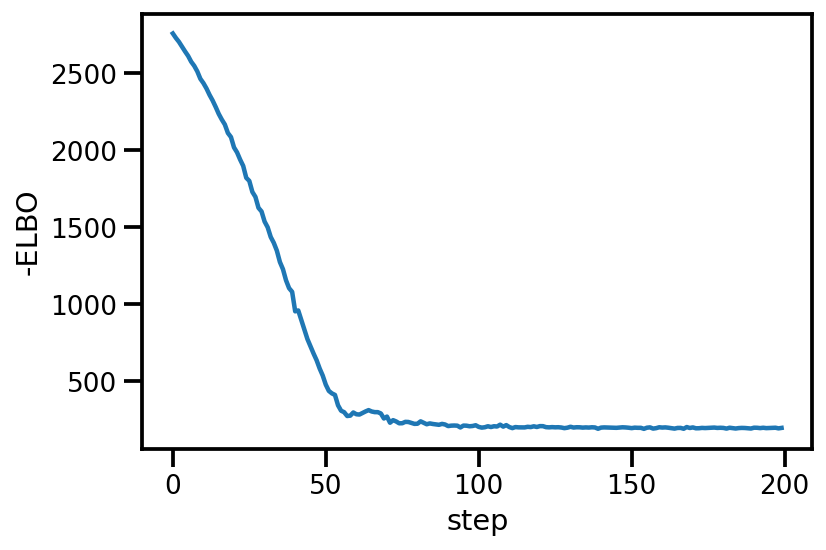

In [14]:
#@title 変分推論
%%time
trend_seasonal_model = build_trend_seasonal_model(y_train)

num_variational_steps = 200
variational_posteriors = variational_inference(trend_seasonal_model, 
                                               y_train, 
                                               num_variational_steps)

# 近似事後分布からのサンプルを取得
q_samples = variational_posteriors.sample(50)

print("Inferred parameters:")
for param in trend_seasonal_model.parameters:
    print("{0}: {1:.3g} +- {2:.3g}".format(param.name,
                                           np.mean(q_samples[param.name], axis=0),
                                           np.std(q_samples[param.name], axis=0)))

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f770f6d37d0>)

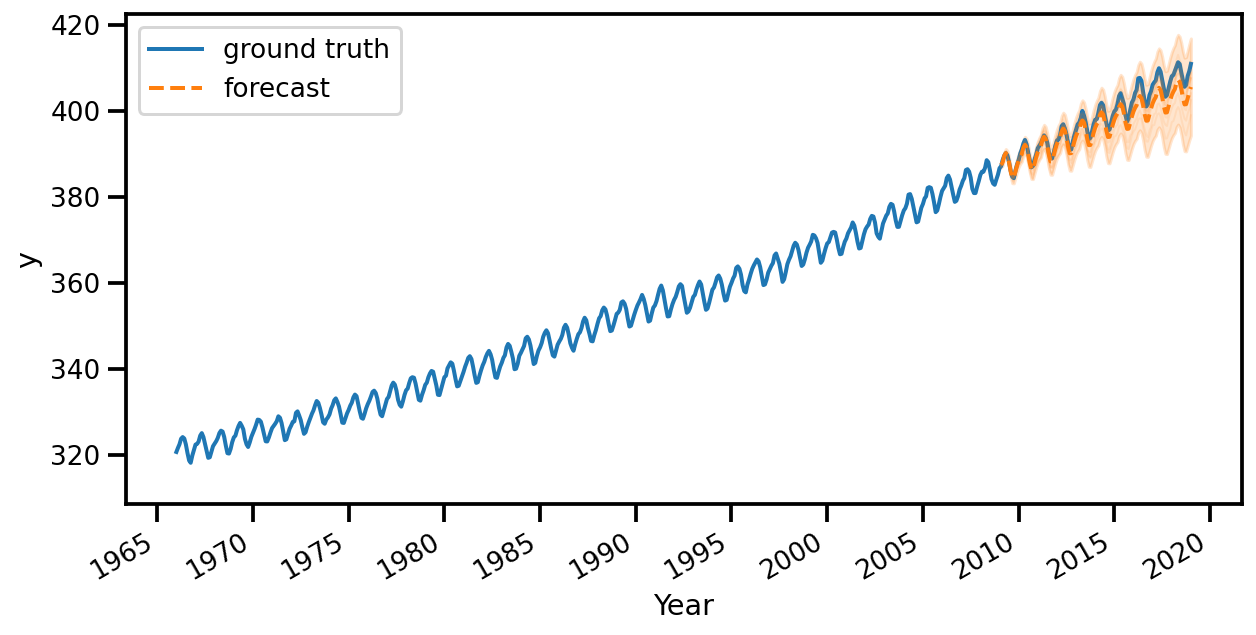

In [15]:
#@title Plot forecast
# パラメータの事後分布からのサンプルを用いて、未来の観測値の予測分布を算出する。
# tfd.MixtureSameFamilyが返される。混合要素数は事後分布からのサンプル数となる。
pred_dist = tfp.sts.forecast(
    model=trend_seasonal_model,
    observed_time_series=y_train,
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast_steps)


# 予測分布の平均、標準偏差を算出、予測分布からのサンプルも取得
num_samples=10
(
    pred_mean,
    pred_scale,
    pred_samples
) = (
    pred_dist.mean().numpy()[..., 0],
    pred_dist.stddev().numpy()[..., 0],
    pred_dist.sample(num_samples).numpy()[..., 0]
    )

plot_forecast(dates, y, pred_mean, pred_scale, pred_samples, x_loc, x_fmt)

In [16]:
print('MAE (local level model): {:.2f}'.format(
    mean_absolute_error(pred_mean, y_test)))

MAE (local level model): 2.07


(<Figure size 720x432 with 2 Axes>,
 OrderedDict([('LocalLinearTrend/',
               <matplotlib.axes._subplots.AxesSubplot at 0x7f778d8c0d90>),
              ('Seasonal/',
               <matplotlib.axes._subplots.AxesSubplot at 0x7f770ede7710>)]))

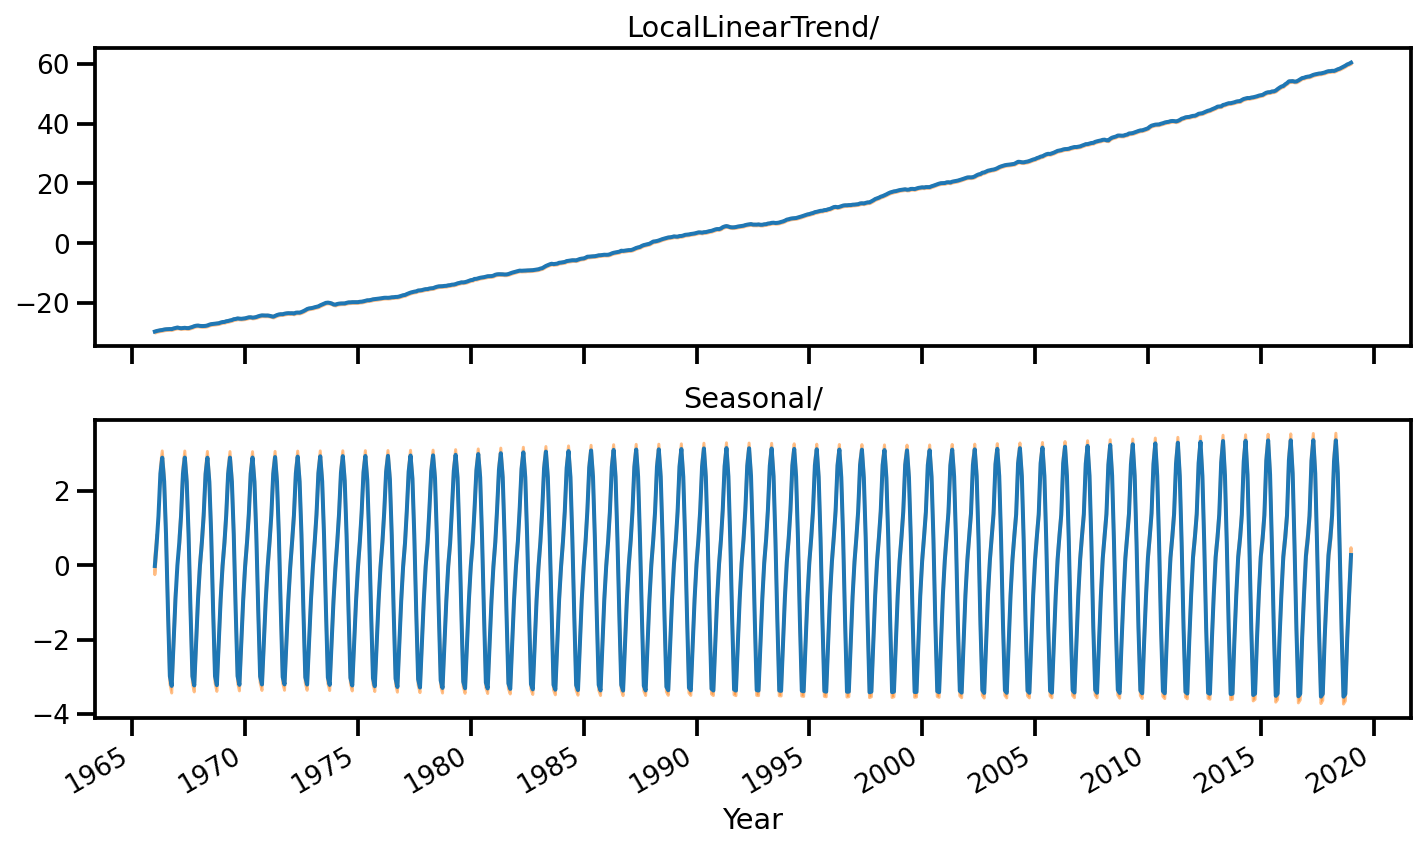

In [17]:
# 状態成分ごとの事後分布を算出し、各成分を表すStructuralTimeSeriesインスタンスをkey, 
# 事後分布を表すtfp.DistibutionインスタンスをvalueとするOrderedDictを返す。
component_dists = sts.decompose_by_component(
    trend_seasonal_model,
    observed_time_series=y,
    parameter_samples=q_samples)

# 各成分の事後分布の平均と標準偏差を算出
component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

# 成分ごとのプロット
plot_components(dates, component_means, component_stddevs, 
                x_locator=x_loc, x_formatter=x_fmt)

In [18]:
%load_ext watermark
%watermark --iversions

numpy                 : 1.21.6
seaborn               : 0.11.2
tensorflow            : 2.8.0+zzzcolab20220506162203
pandas                : 1.3.5
tensorflow_probability: 0.16.0
IPython               : 5.5.0
matplotlib            : 3.2.2

